In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from keras.optimizers import Adam, SGD
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from hyperopt import hp, tpe, fmin, STATUS_OK, Trials
from hyperopt.pyll.base import scope
from datetime import datetime, timedelta
import tensorflow as tf
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError, MeanSquaredError
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import plotly.express as px

## Uploading data

In [2]:
elect = pd.read_excel("hourly_electricity.xlsx")

In [3]:
elect["date"] = pd.to_datetime(elect["date"], format='%d.%m.%Y')

In [4]:
elect["time"] = elect["date"].astype(str) + " " + elect["hour"].astype(str)

In [5]:
elect["time"] = pd.to_datetime(elect["time"])
elect.sort_values(by = "time", inplace = True)

In [6]:
elect.set_index("time", inplace=True)

In [7]:
elect.drop(columns=["hour", "date"], inplace = True)

### Functions for fourier series features to capture multiple seasonality

In [8]:
def fourier_daily(df, k):
    dff = pd.DataFrame({"date": df.index})
    t=df.index.hour+1
    dff.set_index("date", inplace=True)
    for i in range(1, k+1):
        dff["sin_D"+str(i-1)] = np.sin(2*i*np.pi*t/24)
        dff["cos_D"+str(i-1)] = np.cos(2*i*np.pi*t/24)
    return dff
    
    

In [9]:
def fourier_weekly(df, k):
    dff = pd.DataFrame({"date": df.index})
    t=df.index.day_of_year-1 + (df.index.hour+1)
    dff.set_index("date", inplace=True)
    for i in range(1, k+1):
        dff["sin_W"+str(i-1)] = np.sin(2*i*np.pi*t/168)
        dff["cos_W"+str(i-1)] = np.cos(2*i*np.pi*t/168)
    return dff

In [10]:
def fourier_yearly(df, k):
    dff = pd.DataFrame({"date": df.index})
    t=(df.index.day_of_year-1)*24 + (df.index.hour+1)
    dff.set_index("date", inplace=True)
    for i in range(1, k+1):
        dff["sin_Y"+str(i-1)] = np.sin(2*i*np.pi*t/24*365.25)
        dff["cos_Y"+str(i-1)] = np.cos(2*i*np.pi*t/24*365.25)
    return dff

## Data Preparation for LSTM

In [11]:
elect_df = elect.copy()

In [12]:
elect_model = pd.concat([elect_df, fourier_daily(elect_df, 1), fourier_weekly(elect_df, 1),fourier_yearly(elect_df, 1)], axis=1)

In [13]:
class lstm_predictor:
    
    def __init__(self, data, target_col, input_size, output_size, learning_rate, train_date_cutoff):
        self.input_size = input_size
        self.output_size = output_size
        self.data_all = data
        self.target_col = target_col
        self.data = np.array(data[self.target_col]).reshape(-1,1)
        self.train_date_cutoff = train_date_cutoff
        self.test_date_cutoff = pd.to_datetime(self.train_date_cutoff) + timedelta(1)
        self.learning_rate = learning_rate
        self.scaler = MinMaxScaler(feature_range=(0,1))
        self.scaler_p = MinMaxScaler(feature_range=(0,1))
        self.model = None
        
    def scale_split(self):
        data_scaled = self.scaler.fit_transform(self.data_all)
        len_train = len(self.data_all[:self.train_date_cutoff])
        len_test = len(self.data_all[self.test_date_cutoff:])
        
        train = data_scaled[:-len_test]
        test = data_scaled[-len_test:]
        return train, test
        
    def one_step_preprocess(self, data):
        X, Y = [], []
        for i in range(len(data)-self.input_size-1):
            a = np.concatenate((data[i:i+self.input_size, 0], data[(i+self.input_size), 1:])) # for additional regressors
            # a = np.array(data[i:i+, 0]) ### if there is no additional regressors use this
            X.append(a)
            Y.append(data[(i+self.input_size), 0])
        X, y = np.array(X), np.array(Y)
        X = X.reshape(X.shape[0], X.shape[1] , 1)
        return X, y
    
    def multiple_step_preprocess(self, data):
        X, Y = [], []
        for i in range(len(data)-self.input_size-self.output_size-1):
            a = np.column_stack((data[i:i+self.input_size, 0].reshape(-1,1), 
                                 data[i+self.input_size:i+self.input_size+self.output_size:, 1:])) #### additional refressors are added with np.columnstack
            X.append(a)
            Y.append(data[i+self.input_size:i+self.input_size+self.output_size, 0])
        return np.array(X), np.array(Y)
    
    def model_fit(self, Xtrain, Ytrain, Xtest, Ytest, epoch, batchsize):
        self.model=Sequential()
        self.model.add(LSTM(32,return_sequences=True, input_shape=(Xtrain.shape[1],Xtrain.shape[2])))
        self.model.add(LSTM(32))
        self.model.add(Dense(1))
        
        optimizer = Adam(learning_rate=self.learning_rate)
        self.model.compile(loss='mean_squared_error',optimizer=optimizer, metrics=[RootMeanSquaredError(), MeanAbsoluteError()])
        es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', mode='min',patience=20)
        lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_root_mean_squared_error', patience=10,factor = 0.2)
        self.model.fit(Xtrain,Ytrain, validation_data=(Xtest,Ytest),epochs=epoch,batch_size=batchsize,verbose=1,callbacks = [lr_callback, es_callback])
    
    def future_predictions(self, train, test, x_shape,  n_features):
        temp_input = train[-self.input_size:, 0].tolist() # last 30 days of the train data

        predicitons=[]
        n_steps= len(test)
        i=0
        while(i<n_steps):

            if(len(temp_input)>self.input_size):
                x_input = np.concatenate((np.array(temp_input[-self.input_size:]), test[i, 1:]))
                #x_input=np.array(temp_input[1:]) if there is no additional regressors

                x_input = x_input.reshape((1, x_shape, n_features))
                yhat = self.model.predict(x_input, verbose=0)

                temp_input.extend(yhat[0].tolist())
                temp_input=temp_input[1:]
                print(str(len(temp_input)) + " forecast "+ str(i) + " run")
                predicitons.extend(yhat.tolist())
                i=i+1
            else:
                x_input = np.concatenate((train[-self.input_size:, 0], test[i, 1:]))
                x_input = x_input.reshape((1, x_shape, n_features))
                yhat = self.model.predict(x_input, verbose=0)
                
                temp_input.extend(yhat[0].tolist())
                print(str(len(temp_input)) + " forecast "+ str(i) + " run")
                predicitons.extend(yhat.tolist())
                i=i+1
        actual_scaled = self.scaler_p.fit_transform(self.data)
        yhat = self.scaler_p.inverse_transform(np.array(predicitons).reshape(-1,1))
        return yhat
    
    def evaluate(self, yhat):
        test_eval = self.data_all[self.test_date_cutoff:]
        test_eval = pd.DataFrame(test_eval[self.target_col])
        test_eval["forecasted"] = yhat
        test_eval["mape"] = abs(test_eval["forecasted"]-test_eval[self.target_col])*100/test_eval[self.target_col]
        mape = test_eval["mape"].mean()
        return test_eval, mape
        
    

In [14]:
lstm_musti = lstm_predictor(data=elect_model, target_col = "electricity",
                            input_size=24, output_size=1, learning_rate=0.001, train_date_cutoff="2022-11-30")

In [15]:
train, test = lstm_musti.scale_split()

In [16]:
X_train, y_train = lstm_musti.one_step_preprocess(train)

In [17]:
X_test, y_test = lstm_musti.one_step_preprocess(test)

In [18]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((51815, 30, 1), (51815,), (1393, 30, 1), (1393,))

In [19]:
lstm_musti.model_fit(X_train, y_train, X_test, y_test, epoch=100, batchsize=64)

Epoch 1/100
810/810 [==============================] - 21s 22ms/step - loss: 0.0131 - root_mean_squared_error: 0.1145 - mean_absolute_error: 0.0914 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0867 - val_mean_absolute_error: 0.0681 - lr: 0.0010
Epoch 2/100
810/810 [==============================] - 17s 21ms/step - loss: 0.0040 - root_mean_squared_error: 0.0629 - mean_absolute_error: 0.0466 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0625 - val_mean_absolute_error: 0.0487 - lr: 0.0010
Epoch 3/100
810/810 [==============================] - 17s 21ms/step - loss: 0.0024 - root_mean_squared_error: 0.0494 - mean_absolute_error: 0.0369 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0396 - val_mean_absolute_error: 0.0286 - lr: 0.0010
Epoch 4/100
810/810 [==============================] - 17s 21ms/step - loss: 0.0014 - root_mean_squared_error: 0.0375 - mean_absolute_error: 0.0283 - val_loss: 9.0267e-04 - val_root_mean_squared_error: 0.0300 - val_mean_absolute_error: 0.0218 -

810/810 [==============================] - 18s 22ms/step - loss: 2.7417e-04 - root_mean_squared_error: 0.0166 - mean_absolute_error: 0.0126 - val_loss: 2.1121e-04 - val_root_mean_squared_error: 0.0145 - val_mean_absolute_error: 0.0109 - lr: 0.0010
Epoch 33/100
810/810 [==============================] - 18s 22ms/step - loss: 2.6341e-04 - root_mean_squared_error: 0.0162 - mean_absolute_error: 0.0123 - val_loss: 3.9282e-04 - val_root_mean_squared_error: 0.0198 - val_mean_absolute_error: 0.0154 - lr: 0.0010
Epoch 34/100
810/810 [==============================] - 18s 22ms/step - loss: 2.5505e-04 - root_mean_squared_error: 0.0160 - mean_absolute_error: 0.0122 - val_loss: 2.1197e-04 - val_root_mean_squared_error: 0.0146 - val_mean_absolute_error: 0.0110 - lr: 0.0010
Epoch 35/100
810/810 [==============================] - 18s 22ms/step - loss: 2.4976e-04 - root_mean_squared_error: 0.0158 - mean_absolute_error: 0.0120 - val_loss: 3.6477e-04 - val_root_mean_squared_error: 0.0191 - val_mean_absol

810/810 [==============================] - 18s 22ms/step - loss: 1.3531e-04 - root_mean_squared_error: 0.0116 - mean_absolute_error: 0.0088 - val_loss: 1.3042e-04 - val_root_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0084 - lr: 2.0000e-04
Epoch 64/100
810/810 [==============================] - 18s 22ms/step - loss: 1.3384e-04 - root_mean_squared_error: 0.0116 - mean_absolute_error: 0.0088 - val_loss: 1.1804e-04 - val_root_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0079 - lr: 2.0000e-04
Epoch 65/100
810/810 [==============================] - 18s 22ms/step - loss: 1.3273e-04 - root_mean_squared_error: 0.0115 - mean_absolute_error: 0.0087 - val_loss: 1.2005e-04 - val_root_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0080 - lr: 2.0000e-04
Epoch 66/100
810/810 [==============================] - 18s 22ms/step - loss: 1.3242e-04 - root_mean_squared_error: 0.0115 - mean_absolute_error: 0.0087 - val_loss: 1.2517e-04 - val_root_mean_squared_error: 0.0112 - va

Epoch 94/100
810/810 [==============================] - 18s 23ms/step - loss: 1.1345e-04 - root_mean_squared_error: 0.0107 - mean_absolute_error: 0.0080 - val_loss: 1.1197e-04 - val_root_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0077 - lr: 4.0000e-05
Epoch 95/100
810/810 [==============================] - 19s 23ms/step - loss: 1.1328e-04 - root_mean_squared_error: 0.0106 - mean_absolute_error: 0.0080 - val_loss: 1.1420e-04 - val_root_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0078 - lr: 4.0000e-05
Epoch 96/100
810/810 [==============================] - 18s 23ms/step - loss: 1.1333e-04 - root_mean_squared_error: 0.0106 - mean_absolute_error: 0.0080 - val_loss: 1.1356e-04 - val_root_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0078 - lr: 4.0000e-05
Epoch 97/100
810/810 [==============================] - 18s 23ms/step - loss: 1.1298e-04 - root_mean_squared_error: 0.0106 - mean_absolute_error: 0.0080 - val_loss: 1.1330e-04 - val_root_mean_squared_error

In [20]:
yhat = lstm_musti.future_predictions(train, test, X_train.shape[1], X_train.shape[2])

25 forecast 0 run
25 forecast 1 run
25 forecast 2 run
25 forecast 3 run
25 forecast 4 run
25 forecast 5 run
25 forecast 6 run
25 forecast 7 run
25 forecast 8 run
25 forecast 9 run
25 forecast 10 run
25 forecast 11 run
25 forecast 12 run
25 forecast 13 run
25 forecast 14 run
25 forecast 15 run
25 forecast 16 run
25 forecast 17 run
25 forecast 18 run
25 forecast 19 run
25 forecast 20 run
25 forecast 21 run
25 forecast 22 run
25 forecast 23 run
25 forecast 24 run
25 forecast 25 run
25 forecast 26 run
25 forecast 27 run
25 forecast 28 run
25 forecast 29 run
25 forecast 30 run
25 forecast 31 run
25 forecast 32 run
25 forecast 33 run
25 forecast 34 run
25 forecast 35 run
25 forecast 36 run
25 forecast 37 run
25 forecast 38 run
25 forecast 39 run
25 forecast 40 run
25 forecast 41 run
25 forecast 42 run
25 forecast 43 run
25 forecast 44 run
25 forecast 45 run
25 forecast 46 run
25 forecast 47 run
25 forecast 48 run
25 forecast 49 run
25 forecast 50 run
25 forecast 51 run
25 forecast 52 run
25 

25 forecast 416 run
25 forecast 417 run
25 forecast 418 run
25 forecast 419 run
25 forecast 420 run
25 forecast 421 run
25 forecast 422 run
25 forecast 423 run
25 forecast 424 run
25 forecast 425 run
25 forecast 426 run
25 forecast 427 run
25 forecast 428 run
25 forecast 429 run
25 forecast 430 run
25 forecast 431 run
25 forecast 432 run
25 forecast 433 run
25 forecast 434 run
25 forecast 435 run
25 forecast 436 run
25 forecast 437 run
25 forecast 438 run
25 forecast 439 run
25 forecast 440 run
25 forecast 441 run
25 forecast 442 run
25 forecast 443 run
25 forecast 444 run
25 forecast 445 run
25 forecast 446 run
25 forecast 447 run
25 forecast 448 run
25 forecast 449 run
25 forecast 450 run
25 forecast 451 run
25 forecast 452 run
25 forecast 453 run
25 forecast 454 run
25 forecast 455 run
25 forecast 456 run
25 forecast 457 run
25 forecast 458 run
25 forecast 459 run
25 forecast 460 run
25 forecast 461 run
25 forecast 462 run
25 forecast 463 run
25 forecast 464 run
25 forecast 465 run


25 forecast 826 run
25 forecast 827 run
25 forecast 828 run
25 forecast 829 run
25 forecast 830 run
25 forecast 831 run
25 forecast 832 run
25 forecast 833 run
25 forecast 834 run
25 forecast 835 run
25 forecast 836 run
25 forecast 837 run
25 forecast 838 run
25 forecast 839 run
25 forecast 840 run
25 forecast 841 run
25 forecast 842 run
25 forecast 843 run
25 forecast 844 run
25 forecast 845 run
25 forecast 846 run
25 forecast 847 run
25 forecast 848 run
25 forecast 849 run
25 forecast 850 run
25 forecast 851 run
25 forecast 852 run
25 forecast 853 run
25 forecast 854 run
25 forecast 855 run
25 forecast 856 run
25 forecast 857 run
25 forecast 858 run
25 forecast 859 run
25 forecast 860 run
25 forecast 861 run
25 forecast 862 run
25 forecast 863 run
25 forecast 864 run
25 forecast 865 run
25 forecast 866 run
25 forecast 867 run
25 forecast 868 run
25 forecast 869 run
25 forecast 870 run
25 forecast 871 run
25 forecast 872 run
25 forecast 873 run
25 forecast 874 run
25 forecast 875 run


25 forecast 1226 run
25 forecast 1227 run
25 forecast 1228 run
25 forecast 1229 run
25 forecast 1230 run
25 forecast 1231 run
25 forecast 1232 run
25 forecast 1233 run
25 forecast 1234 run
25 forecast 1235 run
25 forecast 1236 run
25 forecast 1237 run
25 forecast 1238 run
25 forecast 1239 run
25 forecast 1240 run
25 forecast 1241 run
25 forecast 1242 run
25 forecast 1243 run
25 forecast 1244 run
25 forecast 1245 run
25 forecast 1246 run
25 forecast 1247 run
25 forecast 1248 run
25 forecast 1249 run
25 forecast 1250 run
25 forecast 1251 run
25 forecast 1252 run
25 forecast 1253 run
25 forecast 1254 run
25 forecast 1255 run
25 forecast 1256 run
25 forecast 1257 run
25 forecast 1258 run
25 forecast 1259 run
25 forecast 1260 run
25 forecast 1261 run
25 forecast 1262 run
25 forecast 1263 run
25 forecast 1264 run
25 forecast 1265 run
25 forecast 1266 run
25 forecast 1267 run
25 forecast 1268 run
25 forecast 1269 run
25 forecast 1270 run
25 forecast 1271 run
25 forecast 1272 run
25 forecast 1

In [22]:
test_eval, mape = lstm_musti.evaluate(yhat)

In [23]:
mape # accuracy error

14.516816007209059

In [24]:
test_eval.head()

,electricity,forecasted,mape
2022-12-01 00:00:00,32927.67,33139.448984,0.643164
2022-12-01 01:00:00,31154.79,31384.062372,0.735914
2022-12-01 02:00:00,30345.32,30218.474291,0.418007
2022-12-01 03:00:00,29443.10,29578.624310,0.460292
2022-12-01 04:00:00,29299.30,29421.379721,0.416664


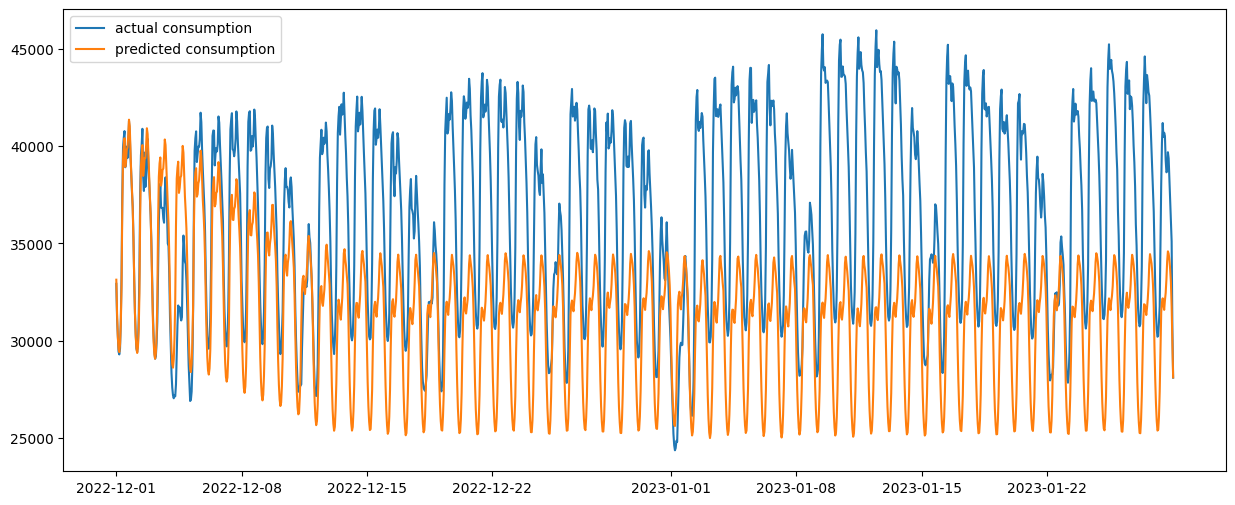

In [25]:
fig, ax = plt.subplots(figsize = (15,6))
ax.plot(test_eval.index, test_eval["electricity"], label = "actual consumption", color = "C0")
ax.plot(test_eval.index, test_eval["forecasted"], label = "predicted consumption", color = "C1")
plt.legend(loc="upper left")
plt.show()